<a href="https://colab.research.google.com/github/divyuk/deep-learning/blob/dl-1/Batch_Normalization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [15]:
#import Libraries

#for number manipulation
import numpy as np
import scipy.stats as stats

#for dataset
import pandas as pd

# for DL modeling
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader,TensorDataset
from sklearn.model_selection import train_test_split

# for data visuialization
import matplotlib.pyplot as plt
import seaborn as sns

In [16]:
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-red.csv"
data = pd.read_csv(url, sep=';')


# Reorganize the dataset

In [17]:
# z-score all columns except for quality
cols = data.keys()
cols = cols.drop('quality')
data[cols] = data[cols].apply(stats.zscore)

# create a new column for binarized (boolean) quality
data['boolQuality'] = 0
# data['boolQuality'][data['quality']<6] = 0 # implicit in the code! just here for clarity
data['boolQuality'][data['quality']>5] = 1

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':


In [18]:
# convert from pandas dataframe to tensor
dataT  = torch.tensor( data[cols].values ).float()
labels = torch.tensor( data['boolQuality'].values ).float()

print( dataT.shape )
print( labels.shape )
print(labels[0:4])
# labels not in 1D array but 2D
labels = labels[:,None]
print( labels.shape )
print(labels[0:4])

torch.Size([1599, 11])
torch.Size([1599])
tensor([0., 0., 0., 1.])
torch.Size([1599, 1])
tensor([[0.],
        [0.],
        [0.],
        [1.]])


In [19]:
# use scikitlearn to split the data
train_data,test_data, train_labels,test_labels = train_test_split(dataT, labels, test_size=.1)

train_dataDataset = TensorDataset(train_data,train_labels)
test_dataDataset  = TensorDataset(test_data,test_labels)


# train and test dataloaders
test_loader  = DataLoader(test_dataDataset,batch_size=test_dataDataset.tensors[0].shape[0])
train_loader = DataLoader(train_dataDataset,batch_size=32, shuffle=True, drop_last=True)

# Model


In [20]:
class ANNwine(nn.Module):
  def __init__(self):
    super().__init__()

    # Input Layer
    self.input = nn.Linear(11,32)
    # Hidden Layer
    self.fullconnected1 = nn.Linear(32,32)
    self.bnorm1 = nn.BatchNorm1d(32) # the number of units into this layer
    self.fullconnected2 = nn.Linear(32,32)
    self.bnorm2 = nn.BatchNorm1d(32) # the number of units into this layer
    # Output Layer
    self.output = nn.Linear(32,1)

    # Forward Pass
  def forward(self,x,doBN):

    # The first input is already Normalized
    x = F.relu(self.input(x))

    if doBN:
      # hidden layer 1
      x = self.bnorm1(x) # batchnorm
      x = self.fullconnected1(x)    # weighted combination
      x = F.relu(x)      # activation function

      # hidden layer 2
      x = self.bnorm2(x) # batchnorm
      x = self.fullconnected2(x)    # weighted combination
      x = F.relu(x)      # activation function
    

    else:
      # hidden layer 1
      x = F.relu( self.fullconnected1(x) )

      # hidden layer 2
      x = F.relu( self.fullconnected2(x) )

    # output layer
    return self.output(x)

# Train The Model

In [21]:
numepochs  = 1000

def train_the_model(winenet , train_loader , test_loader , doBN=True):
  
  # 1) Define Loss function and Optimizer
  lossfun = nn.BCEWithLogitsLoss()
  optimizer = torch.optim.SGD(winenet.parameters() , lr=0.01)

  # Initialize Losses
  losses = torch.zeros(numepochs)
  trainAcc = []
  testAcc  = []

  # Loop over one complete pass :: epochs
  for epochi in range(numepochs):

    # Switch on the training mode
    winenet.train()

    # Initialize the batches
    batchAcc = []
    batchLoss = []
    for x,y in train_loader:
      
      # Forward Pass
      yhat = winenet(x,doBN)
      loss = lossfun(yhat , y)

      # BackProp
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      # Loss from the batch
      batchLoss.append(loss.item())
      # Training accuracy for this batch
      batchAcc.append(100*torch.mean(( (yhat>0)==y).float()).item())#.item() ensures that you append only the float values 
                                                                    #to the list rather the tensor itself.
                                                                    # You are basically converting a single element tensor value 
                                                                    #to a python number.
      # end of Batch
    # Now average training accurracy of the batch
    trainAcc.append(np.mean(batchAcc))
    # Get average Loss across the batch
    losses[epochi] = np.mean(batchLoss)

    # Test accuraccy
    winenet.eval()
    xt,yt = next(iter(test_loader))
    with torch.no_grad():
      ytest = winenet(xt,doBN=False)
    testAcc.append(100*torch.mean(( (ytest>0)==yt).float()).item())
  return trainAcc,testAcc,losses
                      

In [22]:
# Without Batch Normalization Activated
winenet = ANNwine()
trainAccNo,testAccNo,lossesNo = train_the_model(winenet , train_loader , test_loader,doBN=False)

# With Batch Normalization Activated
winenet = ANNwine()
trainAccWith,testAccWith,lossesWith = train_the_model(winenet , train_loader , test_loader,doBN=True)

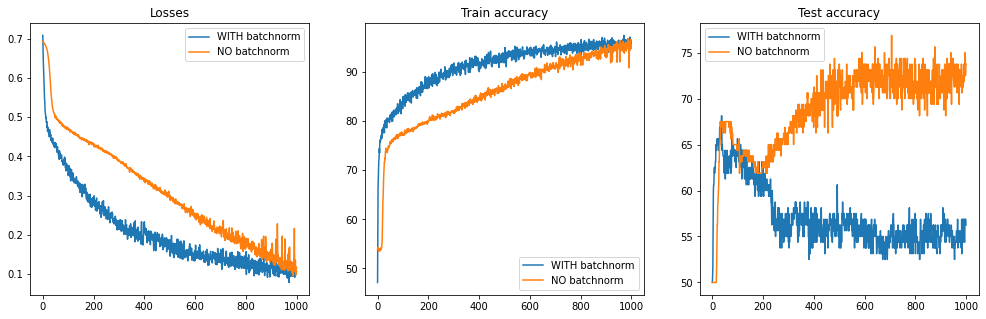

In [23]:
# plot the results
fig,ax = plt.subplots(1,3,figsize=(17,5))

ax[0].plot(lossesWith,label='WITH batchnorm')
ax[0].plot(lossesNo,label='NO batchnorm')
ax[0].set_title('Losses')
ax[0].legend()

ax[1].plot(trainAccWith,label='WITH batchnorm')
ax[1].plot(trainAccNo,label='NO batchnorm')
ax[1].set_title('Train accuracy')
ax[1].legend()

ax[2].plot(testAccWith,label='WITH batchnorm')
ax[2].plot(testAccNo,label='NO batchnorm')
ax[2].set_title('Test accuracy')
ax[2].legend()

plt.show()